# Train Data Exploration Analysis

## Loading Libraries & Training Dataset

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math
import matplotlib.pyplot as plt
from datetime import datetime
import re
import random

In [2]:
filepath_train = '../clean_data/train.csv'
train = pd.read_csv(filepath_train)
train.head()

,Unnamed: 0,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


## Exploration

### Numbers

In [3]:
print('number of unique users :', train.user_id.nunique())
print('number of unique sessions :', train.session_id.nunique())

number of unique users : 617354
number of unique sessions : 745755


### Steps per Session

{'whiskers': [<matplotlib.lines.Line2D at 0x14df1c875c0>,
 'caps': [<matplotlib.lines.Line2D at 0x14df1c87c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x14df1c87208>],
 'medians': [<matplotlib.lines.Line2D at 0x14df1ab0320>],
 'fliers': [<matplotlib.lines.Line2D at 0x14df1ab0668>],
 'means': []}

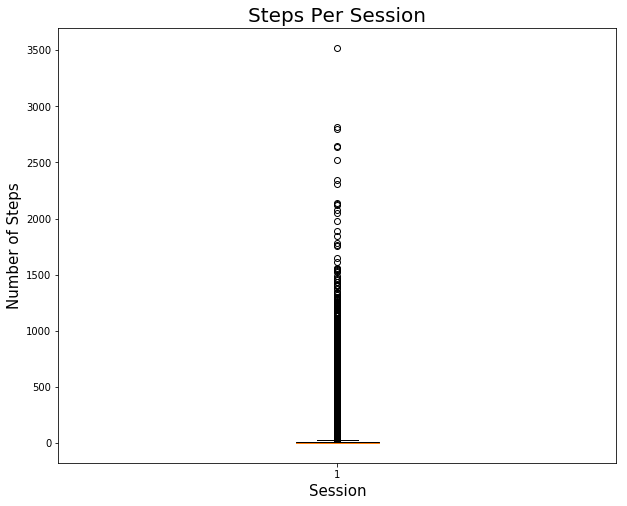

In [5]:
plt.figure(figsize=(10,8))
plt.title('Steps Per Session', fontsize=20)
plt.xlabel('Session', fontsize=15)
plt.ylabel('Number of Steps', fontsize=15)
plt.boxplot(train.groupby('session_id').step.max().values)

(array([7.43264e+05, 2.08300e+03, 2.99000e+02, 7.50000e+01, 1.60000e+01,
        7.00000e+00, 5.00000e+00, 5.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 3.5310e+02, 7.0520e+02, 1.0573e+03, 1.4094e+03,
        1.7615e+03, 2.1136e+03, 2.4657e+03, 2.8178e+03, 3.1699e+03,
        3.5220e+03]),
 <a list of 10 Patch objects>)

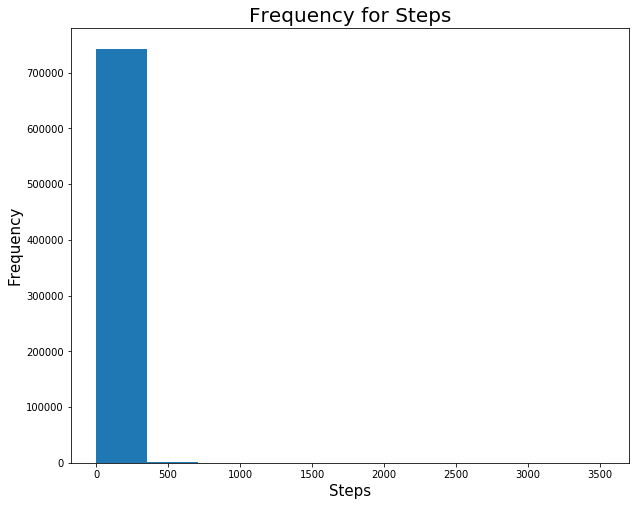

In [6]:
#In other words
plt.figure(figsize=(10,8))
plt.title('Frequency for Steps', fontsize=20)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.hist(train.groupby('session_id').step.max().values, bins=10)

Sessions that are high in steps are computational overhead and don't have valuable information.
One of the outliers has around 3500 steps in just one session.

A preprocessing function of removing sessions with high number of steps is needed.

In [7]:
#investigating this type of sessions
train[train.step > 3000].tail(1)

,Unnamed: 0,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
7729607,9447211,6JWWFFNUMY6Y,3167404ed3197,1541368776,3522,interaction item rating,36455,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN


In [8]:
train[train.session_id == '3167404ed3197'][train.action_type == 'clickout item']

C:\Users\zeyad_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
7726753,9444357,6JWWFFNUMY6Y,3167404ed3197,1541367828,668,clickout item,1819737,TR,"Ankara, Turkey",mobile,Breakfast Included,933451|6365508|6533954|107368|36455|151827|364...,33|32|40|17|26|23|33|36|42|42|26|43|22|29|38|4...


Extended Steps will be applied.

### Number of Clickouts per Session

(array([412391., 135390.,  56690.,  28670.,  15221.,   9240.,   5669.,
          3918.,   2413.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <a list of 9 Patch objects>)

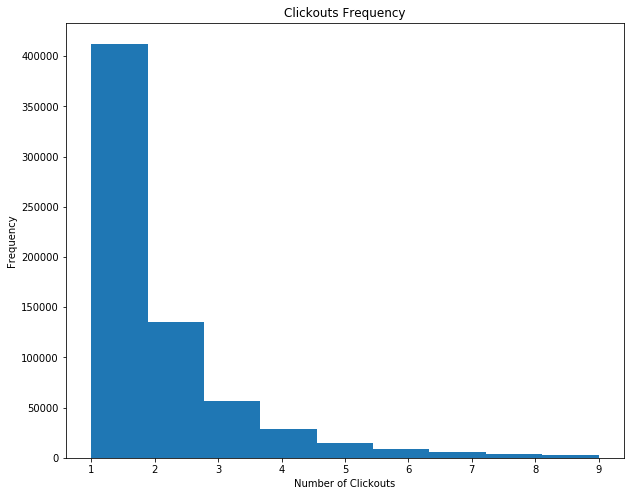

In [11]:
NClickoutSession = train[train.action_type=='clickout item'].groupby('session_id', sort=False).action_type.count()

#creating a dataframe of session_id and NumberOfClickouts
NClickoutSessionDF = NClickoutSession.to_frame()
NClickoutSessionDF.reset_index(level=0, inplace=True)
NClickoutSessionDF = NClickoutSessionDF.rename(columns={'action_type':'NumberOfClickouts'})

#removing sessions with more than 9 clickouts to have number of clickouts histogram
plt.figure(figsize=(10, 8))
plt.title('Clickouts Frequency')
plt.xlabel('Number of Clickouts')
plt.ylabel('Frequency')
plt.hist(NClickoutSessionDF[NClickoutSessionDF.NumberOfClickouts<10].NumberOfClickouts, bins=9)

Sessions with just one clickout is the majority.

### Impressions-Prices

A function that converts impressions into a list of items, and prices into a list of integers that represent prices of these items.

The list of items is in order of the ranks given by Trivago, and the same applies to the prices.

In [13]:
def plot_impression_price(session_id):
  '''
  Desc: Functions that gets a plot of the impressions and the prices of them that visualize what the interacted with items are
        and what the behaviour of the user is in this session checking all the items in the lis.
        
  Input: session_id: String with the session id that needs to be checked
  
  Output: Scatter plot with color visualization'''  
  try:                                          
    impression = train[train.session_id == session_id][train.action_type == 'clickout item'].tail(1).impressions.values[0].split('|')
    price = train[train.session_id == session_id][train.action_type == 'clickout item'].tail(1).prices.values[0].split('|')
    price = list(map(int, price))               #converting list of strings into integers
    clickout_item = train[train.session_id == session_id][train.action_type == 'clickout item'].tail(1).reference.values[0]
    all_interacted_with_items = train[train.session_id == session_id].reference.unique().tolist()
    
    for i in range(len(impression)):            #getting the clickout item
      if clickout_item == impression[i]:
        rank = i
    
    interacted_with_items = []
    interacted_with_items_prices = []
    for item in all_interacted_with_items:      #getting interacted with items
      for i in range(len(impression)):
        if item == impression[i]:
          interacted_with_items.append(item)
          interacted_with_items_prices.append(price[i])
                                                #plotting the output
    plt.figure(figsize=(10,8))
    plt.title('Impressions and Prices', fontsize=30)
    plt.xlabel('Impressions', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.xticks(rotation=90)                     #Interacted with items are in red points
    plt.plot(impression, price, 'o')            #Final clickout item is in black
    plt.plot(interacted_with_items, interacted_with_items_prices, 'o', color='red')
    plt.plot(clickout_item, price[rank] , 'o', color='black')
  except:
    pass  

C:\Users\zeyad_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zeyad_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\zeyad_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


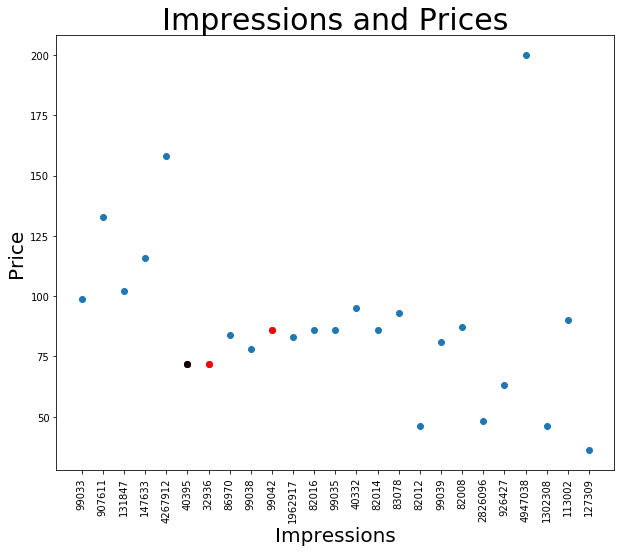

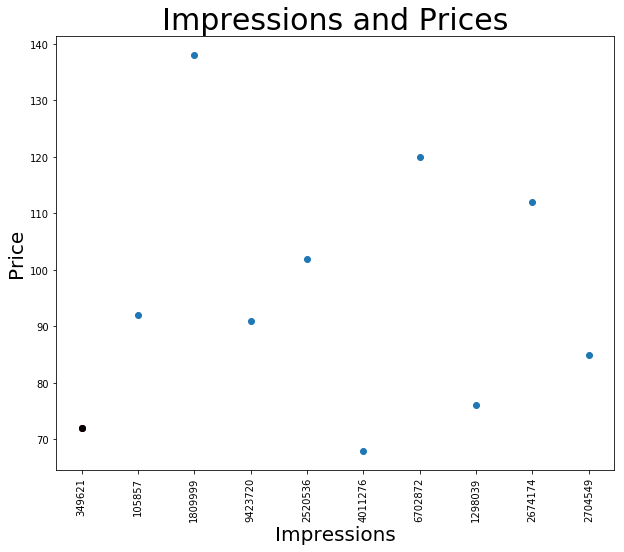

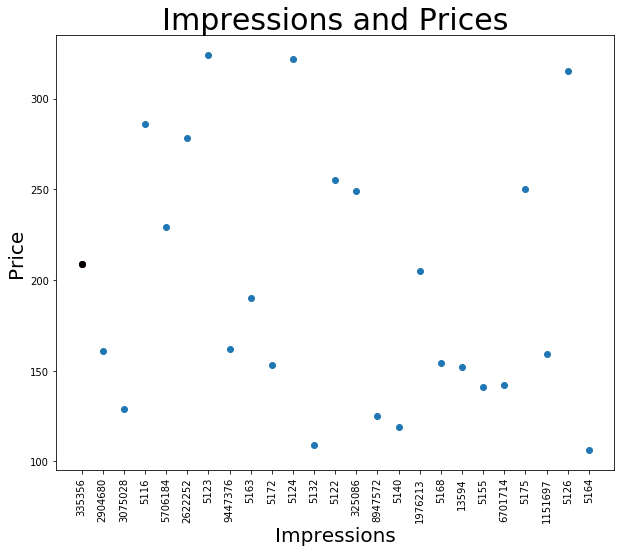

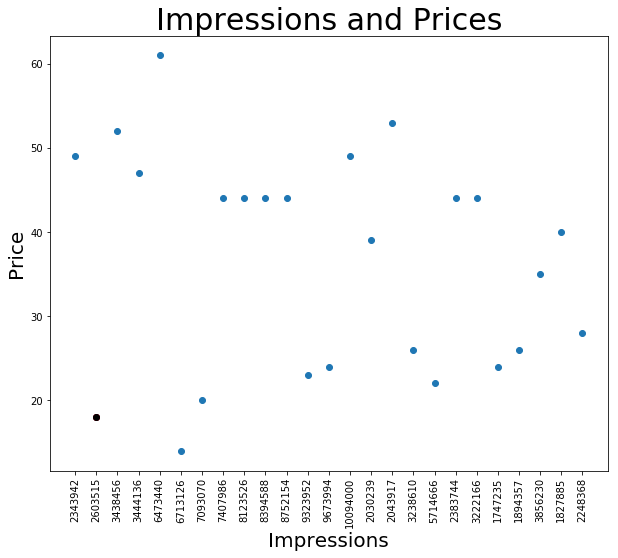

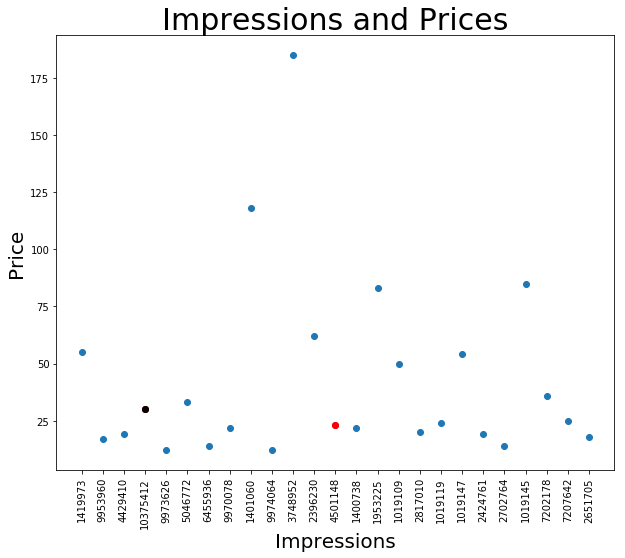

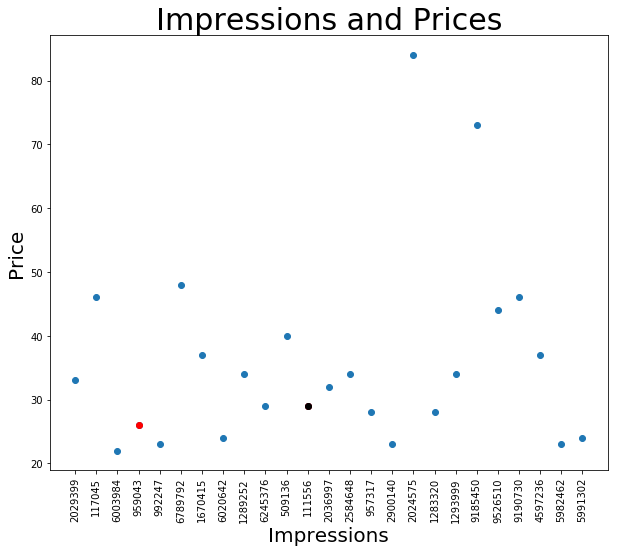

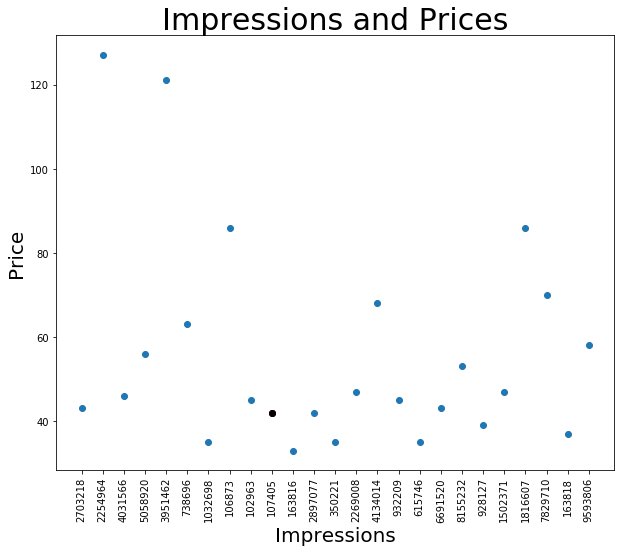

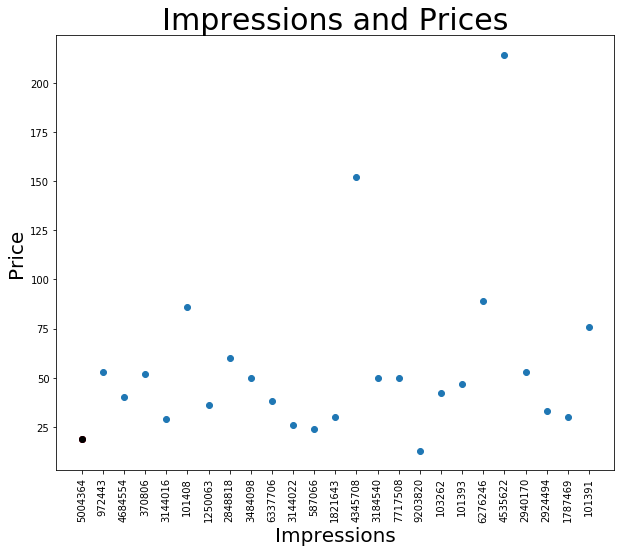

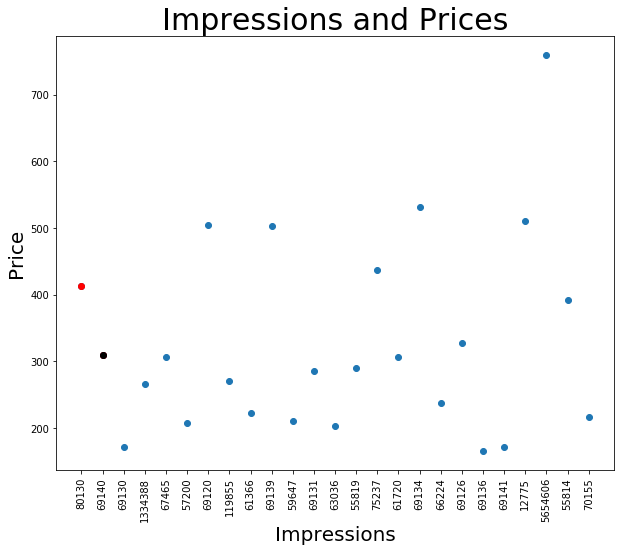

In [14]:
listOfSessions = random.choices(train.session_id.unique(), k=10)
for session_id in listOfSessions:
  plot_impression_price(session_id)

Prices and Ranks are originaly can have an effect on the user choice. These two should be features.

### Total Time Spent

In [15]:
#getting the time spent in each session in seconds
TotalTimeSpentPerSession = train.groupby('session_id').timestamp.last() - train.groupby('session_id').timestamp.first()
TotalTimeSpentPerSession

session_id
00000510f1adc       0
00003f3b20954       0
000056cd97ce2     255
000066611146f      25
00008c1f39c46     200
0000c0fb51e11      51
0000c8490c155      26
0000d4284ff9b     225
0000fd3bf7543       0
00011005327e1     263
000130c2690b4     103
000138ab4f789    3195
00019322edd5d      53
000195d02a8a9     199
00019f78d2c36    5806
0001acb13ccd1     420
0001b9615355c     579
0001c758d8d1f    1961
0001c9c2e444f      85
0001e1f9f413b    1438
0001e610ce498    1604
0001fe0007954     152
000200da92d17      71
00021822e2f69     287
00021d6a859ee       0
00023a654b3f2       0
0002461f28967     100
00025affb7f5f     227
00025bc91dd32      49
000263df674fa     293
                 ... 
ffff2b77b0ac5     493
ffff337d56f29       0
ffff42d6da48b      51
ffff55d5f5692     131
ffff69a28ad8f    1124
ffff71cf574ae      61
ffffb1a829d57     165
ffffc3684eb96     140
ffffd71debe43     117
gdq1ljudj7o75       0
gijrb7ktv5dst    2566
hpc4re5voh2j8       0
hs7al6r7e0e6f     648
iu6o13hri9m3t       0

In [16]:
#checking for the values
TotalTimeSpentPerSession.min()

-270818

The minimum value should be 0 (since it is time spent) That shows that something is not consistent in the dataset.

For now, I'll use another functions to get through this, but some of the sessions' steps(rows) for some reason don't lie where it is supposed to be as mentioned in the next cell.

In [17]:
train[train.session_id=='8c41f0b873b0b'].head(2)

,Unnamed: 0,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
975662,1190260,PBIZWRQOUBVE,8c41f0b873b0b,1541544799,1,clickout item,928649,TR,"Istanbul, Turkey",desktop,NaN,928649|2786846|927845|2631584|4414636|37539|98...,129|87|111|167|42|116|71|36|45|80|71|40|45|50|...
8432290,10308397,PBIZWRQOUBVE,8c41f0b873b0b,1541273844,1,interaction item image,4584962,TR,"Istanbul, Turkey",desktop,NaN,NaN,NaN


In [18]:
#using max and min functions instead
TotalTimeSpentPerSession = train.groupby('session_id').timestamp.max() - train.groupby('session_id').timestamp.min()
TotalTimeSpentPerSession.min()

0

{'whiskers': [<matplotlib.lines.Line2D at 0x14df5b70dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x14df5b70320>,
 'boxes': [<matplotlib.lines.Line2D at 0x14df5bac780>],
 'medians': [<matplotlib.lines.Line2D at 0x14df4ce8128>],
 'fliers': [<matplotlib.lines.Line2D at 0x14df4ce82e8>],
 'means': []}

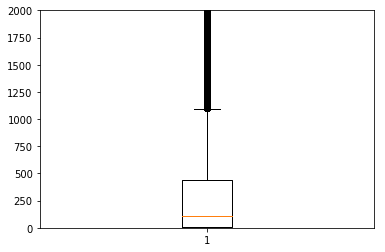

In [19]:
plt.ylim(0, 2000)
plt.boxplot(TotalTimeSpentPerSession)

In [20]:
#percentage of time spent more than the maximum
round((TotalTimeSpentPerSession[TotalTimeSpentPerSession>1140].count()/TotalTimeSpentPerSession.count())*100,2)

11.57

TotalSecondsSpent should be a feature as more features can be obtained from it.

### ReferenceTimeSpent

ReferenceTrain set should be added in Feature Engineering. It will help in getting information about different references in a session.

In [ ]:
# function to remove words from the attribute (to be done)
# #converting words values in referenc into NaN
# ReferenceTrain.reference = ReferenceTrain.reference.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna().astype(int).apply(lambda x: str(x))

# #dropping NaN in reference
# ReferenceTrain = ReferenceTrain.drop(ReferenceTrain[ReferenceTrain.reference.isna()].index.tolist())


In [ ]:
get gobal average of time spent on references (to be done)